In [1]:
# clear variables
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# RESOURCES
# https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6
# https://www.youtube.com/watch?v=R-sQT9AB5cI&ab_channel=AIQCAR
# https://www.dataquest.io/blog/learning-curves-machine-learning/

# TODO: learning curves
# TODO: create a better 'goal' feature, that uses Fixer.io API to convert the goal to current goal value, to account for inflation
# TODO: create feature that shows within a category, how much mony was spent in the last week/month
# TODO: create feature that shows ratio of successful/failed projects in the last month
# TODO: train, test, validation split

# NOTES
# we work with 'ks' as our data set initially, then we create a data set 'data' that only holds a select amount of features

# imports
import sys
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import IPython as ip
from IPython import display as display
import seaborn as sns
import sklearn as sk
import random
import time

# import data
ks = pd.read_csv('ks2018.csv')
print("-"*100,'\nData set: {} samples'.format(ks.shape[0]))
print("-"*100)

# null data
print('Null values:')
print(ks.isnull().sum())
print("-"*100)
print('Percentage missing for "name" %.4f%%' %((ks['name'].isnull().sum()/ks.shape[0])*100))
print('Percentage missing for "usd pledged" %.4f%%' %((ks['usd pledged'].isnull().sum()/ks.shape[0])*100))
print("-"*100)

# possible outcomes
print('Outcomes: ', list(ks.state.unique()))
print("-"*100)

# live projects
live = ks.apply(lambda x: True if x['state'] == 'live' else False , axis=1)
print('The amount of live projects is: ', len(live[live == True].index))
print('This is %.2f%% of the total projects' %((len(live[live == True].index)/ks.shape[0])*100))
print("-"*100)

pd.set_option('display.max_columns', None)

---------------------------------------------------------------------------------------------------- 
Data set: 378661 samples
----------------------------------------------------------------------------------------------------
Null values:
ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64
----------------------------------------------------------------------------------------------------
Percentage missing for "name" 0.0011%
Percentage missing for "usd pledged" 1.0027%
----------------------------------------------------------------------------------------------------
Outcomes:  ['failed', 'canceled', 'successful', 'live', 'undefined', 'suspended']
----

In [3]:
# DATA [CORRECTION, COMPLETION, CONVERSION, DELETION]

# remove live projects, only 0.74% of all data so not a big deal
ks = ks.query('state != "live"')

# set state to 1 if successful, and 0 otherwise, 1 is used for the 'rare class', there are more failed projects thant successful projects
ks['outcome'] = (ks['state'] == 'successful').astype(int)

# remove projects with null names, only 0.0011% of all data so not a big deal
ks.drop(ks[ks.name.isnull()].index, axis=0, inplace=True, errors='ignore')

# remove projects with goal over 30 000 000 since these are probably jokes, they are not realistic, remove outliers
ks.drop(ks[ks.goal > 30000000].index, inplace=True, errors='ignore')

# convert launched and deadline columns to datetime objects
ks['launched'] = pd.to_datetime(ks['launched'])
ks['deadline'] = pd.to_datetime(ks['deadline'])

# give unix-time anomalies a new launch date, 30 days before deadline (median, in order to not mess with data)
ks.loc[pd.DatetimeIndex(ks['launched']).year < 2000, 'launched'] = ks['deadline'] - pd.to_timedelta(30, unit='d')

# select part of dataset to reduce amount of datapoints
ks = ks.sample(1000) #reduce to 20.000 random datapoints

print(ks.head(5))

                ID                                  name        category  \
267953   433384280  ALBUM OF A HEARTIST CALLED THE BTMKR           Music   
373758   974574948                   Searching for Proof     Documentary   
130536  1662730313          J'ba fofi. King of arachnids     Documentary   
341165   807763197            Drop & Fry Fried ice Cream            Food   
287498   532701307        The Otto's: Live Album and DVD  Country & Folk   

       main_category currency   deadline     goal            launched  \
267953         Music      EUR 2015-08-21  85000.0 2015-07-22 18:55:48   
373758  Film & Video      USD 2016-11-10  10000.0 2016-09-26 21:11:14   
130536  Film & Video      GBP 2015-03-23  50000.0 2015-02-18 01:07:31   
341165          Food      USD 2017-07-29  30000.0 2017-05-30 22:52:51   
287498         Music      AUD 2014-06-27   1500.0 2014-06-06 05:45:56   

        pledged       state  backers country  usd pledged  usd_pledged_real  \
267953      0.0      fail

In [4]:
# FEATURE [CREATION, ENGINEERING]

# log transformation on goal column
ks['goal'] = np.log(ks.goal)

# create titlelength feature = length of the project name
ks['tlength'] = ks['name'].str.len()

# create duration feature, value in days, gets rounded up
ks['duration'] = ((ks['deadline'] - ks['launched']) / np.timedelta64(1, 'D')).round(0).astype(int)

# remove projects with duration over 85 since these are outliers
ks.drop(ks[ks.duration > 85].index, inplace=True, errors='ignore')

# create interaction feature, category + country combination
ks['category_country'] = ks['category'] + "_" + ks['country']

# create launch features, month (1 to 12) and day of week (0 to 6)
ks['lyear'] = pd.DatetimeIndex(ks['launched']).year
ks['lmonth'] = pd.DatetimeIndex(ks['launched']).month
ks['lday'] = pd.DatetimeIndex(ks['launched']).dayofweek
ks['lhour'] = pd.DatetimeIndex(ks['launched']).hour

# create deadline features, month (1 to 12) and day of week (0 to 6)
ks['dyear'] = pd.DatetimeIndex(ks['deadline']).year
ks['dmonth'] = pd.DatetimeIndex(ks['deadline']).month
ks['dday'] = pd.DatetimeIndex(ks['deadline']).dayofweek 

# create launch competition feature
launches = pd.Series(ks.index, index=ks.launched, name="competition").sort_index()
competition = launches.rolling('7d').count() - 1 
competition.index = launches.values
competition = competition.reindex(ks.index)

ks['project_competition'] = competition

# create time since last project in same category feature
def time_since_last_project(series): return series.diff().dt.total_seconds() / 3600.

df = ks[['category', 'launched']].sort_values('launched')
timedeltas = df.groupby('category').transform(time_since_last_project)
timedeltas = timedeltas.fillna(timedeltas.median()).reindex(ks.index)

ks['category_competition'] = timedeltas

# create success ratio feature



# create money spent feature
#def mony_spend_last_month():
    

#df = ks[['category', 'launched', 'deadline', 'usd pledged']].sort_values('launched')
#moneydeltas = df.groupby('category').transform(mony_spend_last_month)
#moneydeltas = moneydeltas.fillna(moneydeltas.median()).reindex(ks.index)

#ks['category_money'] = moneydeltas
#print(df)

# print result
print(ks.head(5))


                ID                                  name        category  \
267953   433384280  ALBUM OF A HEARTIST CALLED THE BTMKR           Music   
373758   974574948                   Searching for Proof     Documentary   
130536  1662730313          J'ba fofi. King of arachnids     Documentary   
341165   807763197            Drop & Fry Fried ice Cream            Food   
287498   532701307        The Otto's: Live Album and DVD  Country & Folk   

       main_category currency   deadline       goal            launched  \
267953         Music      EUR 2015-08-21  11.350407 2015-07-22 18:55:48   
373758  Film & Video      USD 2016-11-10   9.210340 2016-09-26 21:11:14   
130536  Film & Video      GBP 2015-03-23  10.819778 2015-02-18 01:07:31   
341165          Food      USD 2017-07-29  10.308953 2017-05-30 22:52:51   
287498         Music      AUD 2014-06-27   7.313220 2014-06-06 05:45:56   

        pledged       state  backers country  usd pledged  usd_pledged_real  \
267953      0

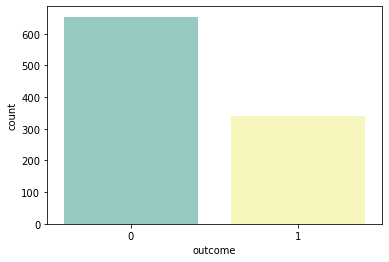

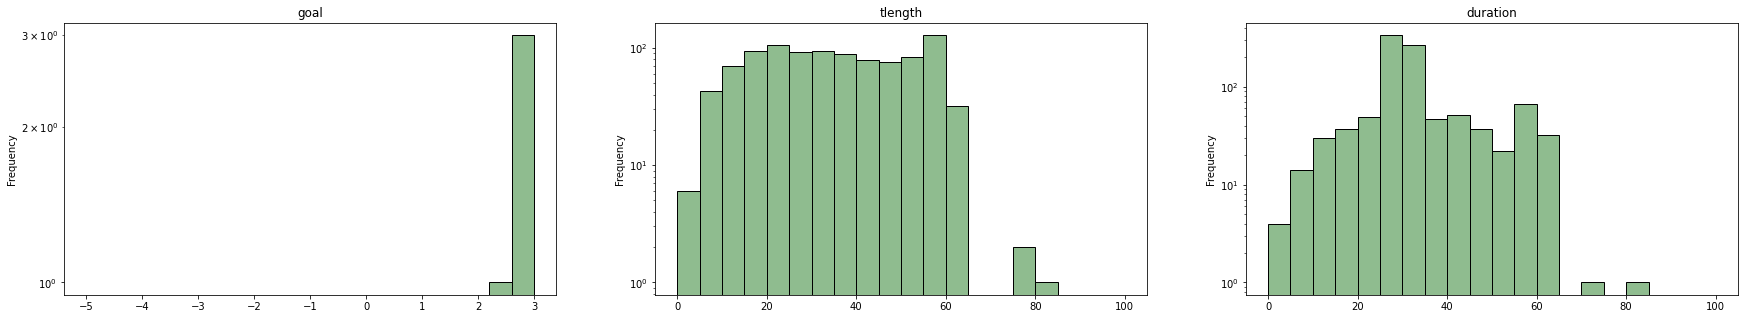

In [5]:
sns.countplot(x = 'outcome', data = ks, palette = 'Set3')


# FIND OUTLIERS
fig, axs = plt.subplots(ncols=3, figsize=(30,5))

# goal, kickstarter maximum is 100.000
axs[0].set_title("goal")
ks['goal'].plot(kind='hist', bins=20, color='darkseagreen', edgecolor='black', log=True, range=[-5,3], ax=axs[0])

# tlength
axs[1].set_title("tlength")
ks['tlength'].plot(kind='hist', bins=20, color='darkseagreen', edgecolor='black', log=True, range=[0,100], ax=axs[1])

# duration
axs[2].set_title("duration")
ks['duration'].plot(kind='hist', bins=20, color='darkseagreen', edgecolor='black', log=True, range=[0,100], ax=axs[2])


plt.show()

In [7]:
# CATEGORICAL ENCODING (one-hot encoding, label encoding, count encoding, target encoding, catboost encoding)

from sklearn.preprocessing import LabelEncoder
import category_encoders as ce

# categorical features to be encoded
features = ['category', 'currency', 'country', 'category_country']

# encoders
l_encoder = LabelEncoder() # label encoding, encode target labels with value between 0 and n_classes-1.
c_encoder = ce.CountEncoder() # count encoding, replaces each categorical value with the number of times it appears in the dataset
t_encoder = ce.TargetEncoder(cols=features) # target encoding, replaces a categorical value with the average value of the target for that value of the feature
cb_encoder = ce.CatBoostEncoder(cols=features) # catboost encoding, for each row, the target probability is calculated only from the rows before it

# encoded features
l_encoded = ks[features].apply(l_encoder.fit_transform)
c_encoded = c_encoder.fit_transform(ks[features])
t_encoded = t_encoder.fit_transform(ks[features], ks['outcome'])
cb_encoded = cb_encoder.fit_transform(ks[features], ks['outcome'])

# create data set
data = ks[['outcome', 'tlength', 'goal', 'duration', 'lyear', 'lmonth', 'lday', 'lhour', 'dyear', 'dmonth', 'dday', 'project_competition', 'category_competition']].join(t_encoded)

# print result
print(data.head(5))

        outcome  tlength       goal  duration  lyear  lmonth  lday  lhour  \
267953        0       36  11.350407        29   2015       7     2     18   
373758        0       19   9.210340        44   2016       9     0     21   
130536        0       28  10.819778        33   2015       2     2      1   
341165        0       26  10.308953        59   2017       5     1     22   
287498        1       30   7.313220        21   2014       6     4      5   

        dyear  dmonth  dday  project_competition  category_competition  \
267953   2015       8     4                  1.0           1440.752778   
373758   2016      11     3                  2.0           1271.259444   
130536   2015       3     0                  3.0           4337.337778   
341165   2017       7     5                  2.0           2101.437778   
287498   2014       6     4                  2.0            821.741389   

        category  currency   country  category_country  
267953  0.384615  0.125000  0.30769

In [8]:
# FEATURE SELECTION
from sklearn.tree import DecisionTreeClassifier

X = data.drop('outcome', axis = 1).values
y = data['outcome']
dt = DecisionTreeClassifier(random_state=15, criterion = 'entropy', max_depth = 10)
dt.fit(X,y)
fi_col = []
fi = []
for i,column in enumerate(data.drop('outcome', axis = 1)):
    fi_col.append(column)
    fi.append(dt.feature_importances_[i])
fi_col
fi
fi_df = zip(fi_col, fi)
fi_df = pd.DataFrame(fi_df, columns = ['Feature','Feature Importance'])
fi_df = fi_df.sort_values('Feature Importance', ascending = False).reset_index()

# Creating columns to keep
columns_to_keep = fi_df['Feature'][0:10]

print(fi_df)

# feature selection
#data = data[['outcome', 'category_country', 'goal', 'duration', 'tlength', 'category_competition', 'project_competition', 'category']]

# correlations
#data.corr().abs()[['outcome']]


    index               Feature  Feature Importance
0      15      category_country            0.262673
1       1                  goal            0.121879
2       0               tlength            0.104406
3       6                 lhour            0.078412
4      11  category_competition            0.071822
5      12              category            0.066567
6      10   project_competition            0.064651
7       2              duration            0.040067
8       7                 dyear            0.039399
9       4                lmonth            0.034204
10      8                dmonth            0.034148
11      5                  lday            0.031535
12      9                  dday            0.026077
13     14               country            0.013003
14      3                 lyear            0.011158
15     13              currency            0.000000


In [9]:
# SCALE AND SPLIT DATA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# get predictors: goal, duration, project_competition, category, category_country
x_unscaled = data[['goal', 'duration', 'project_competition', 'category', 'category_country']]

# get outcome
y = data['outcome']

# feature scaling/normalizing
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x_unscaled), columns=list(x_unscaled.columns))


# split data into training, testing and validation set (60%, 20%, 20%)
# data -> training + testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# training -> training + cross validation
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

print("-"*35)
print("[60%] x_train:\t", x_train.shape[0])
print("[20%] x_valid:\t", x_valid.shape[0])
print("[20%] x_test:\t", x_test.shape[0])
print("-"*35)

# check if data is nicely spread
# https://imgur.com/a/cCCjKhj
# in the image above you see that the projects with outcome 1 are evenly spread among the sets

-----------------------------------
[60%] x_train:	 597
[20%] x_valid:	 199
[20%] x_test:	 200
-----------------------------------


In [10]:
# LOGISTIC REGRESSION 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
from sklearn import metrics

# create model
model = LogisticRegression(C=1)

# fit model on training data set
model.fit(x_train, y_train)

# test model on cross validation data set
y_pred_valid = model.predict(x_valid) 


# model score: score(test samples, true labels for x)
print("-"*60)
print("Logistic Regression Model Scores")
print('[TRAIN]\t %.2f%%' %(round(model.score(x_train, y_train),5)*100))
print('[VALID]\t %.2f%%' %(round(model.score(x_valid, y_valid),5)*100))
print('[TEST]\t %.2f%%' %(round(model.score(x_test, y_test),5)*100))
print("-"*60)

# classification report: classification_report(y_true, y_pred)
print("Classification Report")
print(classification_report(y_valid, y_pred_valid))
print("-"*60)


------------------------------------------------------------
Logistic Regression Model Scores
[TRAIN]	 74.37%
[VALID]	 69.85%
[TEST]	 71.50%
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.74      0.85      0.79       134
           1       0.56      0.38      0.45        65

    accuracy                           0.70       199
   macro avg       0.65      0.62      0.62       199
weighted avg       0.68      0.70      0.68       199

------------------------------------------------------------


------------------------------------------------------------
[ACCURACY]	 69.85%
[PRECISION]	 55.56%
[RECALL]	 38.46%
------------------------------------------------------------


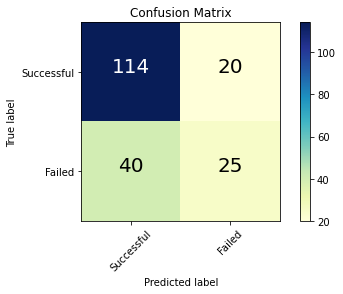

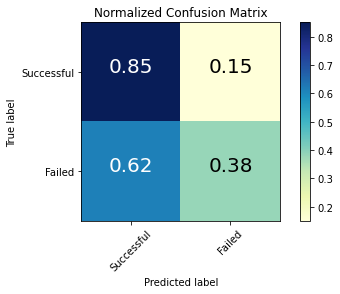

In [11]:
# CONFUSION MATRIX LOGISTIC REGRESSION
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.YlGnBu):
    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
            size="20")
           
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# confusion matrix: confusion_matrix(y_true, y_pred)
cnf_matrix = metrics.confusion_matrix(y_valid, y_pred_valid)
np.set_printoptions(precision=2)
class_names = ['Successful', 'Failed']

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized Confusion Matrix')

# evaluation of confusion matrix
print("-"*60)
print('[ACCURACY]\t %.2f%%' %(metrics.accuracy_score(y_valid, y_pred_valid)*100))
print('[PRECISION]\t %.2f%%' %(metrics.precision_score(y_valid, y_pred_valid)*100))
print('[RECALL]\t %.2f%%' %(metrics.recall_score(y_valid, y_pred_valid)*100))
print("-"*60)


The Log Loss on Training is:  0.49040846410129757
The Log Loss on Testing Dataset is:  0.5511087056400154
ROC Curve


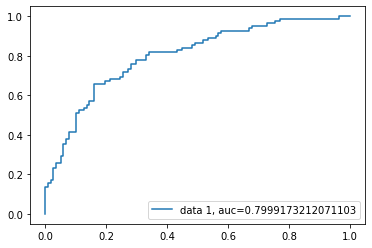

Test AUC score: 0.7999173212071103
------------------------------------------------------------


In [12]:
y_pred_proba_train = model.predict_proba(x_train) # training
y_pred_proba_test = model.predict_proba(x_test) # testing
y_pred_proba_valid = model.predict_proba(x_valid) # validation

# Running Log loss on training
print("The Log Loss on Training is: ", metrics.log_loss(y_train, y_pred_proba_train))
print("The Log Loss on Testing Dataset is: ", metrics.log_loss(y_test, y_pred_proba_test))

# RECEIVER OPERATING CHARACTERISTIC (ROC) CURVE: roc_curve(y_true, y_score)
print("ROC Curve")
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
print(f"Test AUC score: {auc}")
print("-"*60)




/Users/maartenkesters/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/maartenkesters/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/maartenkesters/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1372, in fit
    raise ValueError("This solver needs samples of at least 2 classes"
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1

  warnings.warn("Estimator fit failed. The score on this train-test"


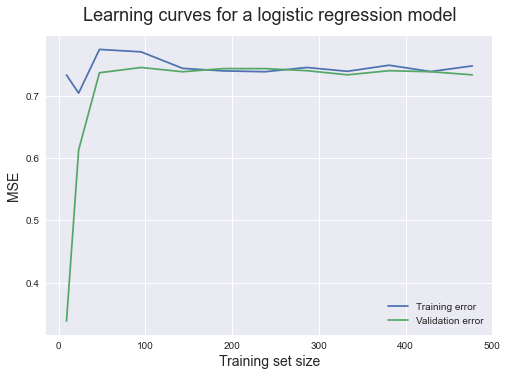

In [13]:
# learning curve for when using whole dataset
# train_sizes, train_scores, validation_scores = learning_curve(estimator = LogisticRegression(), X=x_train, y=y_train, train_sizes = [500, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 1000, 15000, 20000, 25000, 25000, 30000, 35000, 40000, 45000, 50000], cv = 5)
# learning curve for when using part of dataset
train_sizes, train_scores, validation_scores = learning_curve(estimator = LogisticRegression(), X=x_train, y=y_train, train_sizes = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], cv = 5)

train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)

import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a logistic regression model', fontsize = 18, y = 1.03)
plt.legend()
#plt.ylim(0.68,0.703)


In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, random_state=0, shuffle=True)

C_List = np.geomspace(1e-5, 1e5, num=20)

# Logistic Reg CV
Log_reg3 = LogisticRegressionCV(random_state=15, Cs = C_List, solver ='lbfgs')
Log_reg3.fit(x_train, y_train)
print("The CA is:", Log_reg3.score(x_test, y_test))
pred_proba_t = Log_reg3.predict_proba(x_test)
log_loss3 = metrics.log_loss(y_test, pred_proba_t)
print("The Logistic Loss is: ", log_loss3)

print("The optimal C parameter is: ", Log_reg3.C_)


#C_List = np.geomspace(1e-5, 1e5, num=20)
CA = []
Logarithmic_Loss = []

for c in C_List:
    log_reg2 = LogisticRegression(random_state=10, solver = 'lbfgs', C=c)
    log_reg2.fit(x_train, y_train)
    score = log_reg2.score(x_test, y_test)
    CA.append(score)
    print("The CA of C parameter {} is {}:".format(c, score))
    pred_proba_t = log_reg2.predict_proba(x_test)
    log_loss2 = metrics.log_loss(y_test, pred_proba_t)
    Logarithmic_Loss.append(log_loss2)
    print("The Logg Loss of C parameter {} is {}:".format(c, log_loss2))
    print("")
    
    y_pred = log_reg2.predict(x_train)
    cm = metrics.confusion_matrix(y_train, y_pred)
    #cm_norm = cm / cm.sum(axis=1).reshape(-1,1)
    plot_confusion_matrix(cm, normalize=True, classes = model.classes_, title='Confusion matrix', cmap=plt.cm.YlGnBu)
    plt.show()




In [ ]:
# DON'T EXECUTE! crashte bij mij idk waarom
# LightGBM
# Tree-based model that typically provides the best performance, even compared to XGBoost. It's also relatively fast to train.

import lightgbm as lgb
from sklearn import metrics

feature_cols = data.columns.drop('outcome')

dtrain = lgb.Dataset(data[feature_cols], label=data['outcome'])
dvalid = lgb.Dataset(data[feature_cols], label=data['outcome'])

param = {'num_leaves': 64, 'objective': 'binary'}
param['metric'] = 'auc'
num_round = 1000
bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], early_stopping_rounds=10, verbose_eval=False)

ypred = bst.predict(test[feature_cols])
score = metrics.roc_auc_score(test['outcome'], ypred)

# evaluation
print("-"*60)
print('Aread Under Curve (AUC): %.2f%%' %(metrics.roc_auc_score(test['outcome'], ypred)*100))
print("-"*60)

#76.06 (catboost)
#76.83 (target)
#76.34 (count)
#76.33 (label)


In [31]:
# NAIVE BAYES ALGORITHM
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn import metrics

# instantiate logistic regression model
model = GaussianNB()

# fit the model with the data
model.fit(x_train,y_train)

# make predictions
predict_test = model.predict(x_test)

# evaluation
print("-"*60)
print('Accuracy: %.2f%%' %(metrics.accuracy_score(y_test, predict_test)*100))
print('Precision: %.2f%%' %(metrics.precision_score(y_test, predict_test)*100))
print('Recall: %.2f%%' %(metrics.recall_score(y_test, predict_test)*100))
print("-"*60)


------------------------------------------------------------
Accuracy: 73.00%
Precision: 75.00%
Recall: 51.22%
------------------------------------------------------------


In [ ]:
# NEURAL NETWORK
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential()

model.add(layers.Dense(2, activation="relu"))
model.add(layers.Dense(3, activation="relu"))
model.add(layers.Dense(4))

#model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
#model.fit(x_train, y_train, batch_size=32, epochs=50)

#model.summary()

#y_pred = model.predict_classes(x_test)
#print(metrics.accuracy_score(y_test, y_pred))



In [30]:
# SUPORRT VECTOR MACHINES
from sklearn import svm
from sklearn import metrics

# Split dataset in train, validate, test sets
# x_train, x_valid, x_test, y_train, y_valid, y_test

# Create a svm Classifier
clf = svm.SVC(kernel='rbf') # Linear Kernel, or radial basis function?

# Train the model using the training sets
clf.fit(x_train, y_train)

# test model on cross validation data set
y_pred_valid_SVM = clf.predict(x_valid)

# model score: score(test samples, true labels for x)
print("-"*60)
print("Support Vector Machines Model Scores")
print('[TRAIN]\t %.2f%%' %(round(clf.score(x_train, y_train),5)*100))
print('[VALID]\t %.2f%%' %(round(clf.score(x_valid, y_valid),5)*100))
print('[TEST]\t %.2f%%' %(round(clf.score(x_test, y_test),5)*100))
print("-"*60)

# classification report: classification_report(y_true, y_pred)
print("Classification Report")
print(classification_report(y_valid, y_pred_valid_SVM))
print("-"*60)

# evaluationg the model
#print("Accuracy:",metrics.accuracy_score(y_test, y_pred_valid))
#print("Precision:",metrics.precision_score(y_test, y_pred_valid))
#print("Recall:",metrics.recall_score(y_test, y_pred_valid))

------------------------------------------------------------
Support Vector Machines Model Scores
[TRAIN]	 75.38%
[VALID]	 69.85%
[TEST]	 67.50%
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.71      0.93      0.81       134
           1       0.61      0.22      0.32        65

    accuracy                           0.70       199
   macro avg       0.66      0.57      0.56       199
weighted avg       0.68      0.70      0.65       199

------------------------------------------------------------


------------------------------------------------------------
[ACCURACY]	 67.84%
[PRECISION]	 51.61%
[RECALL]	 24.62%
------------------------------------------------------------


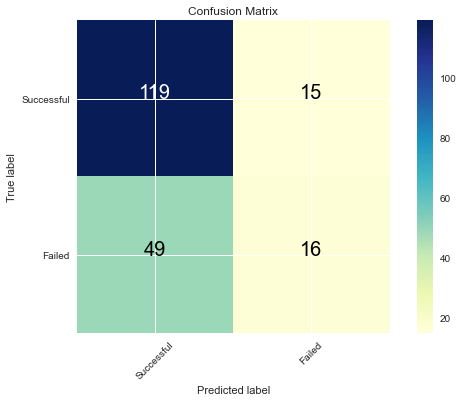

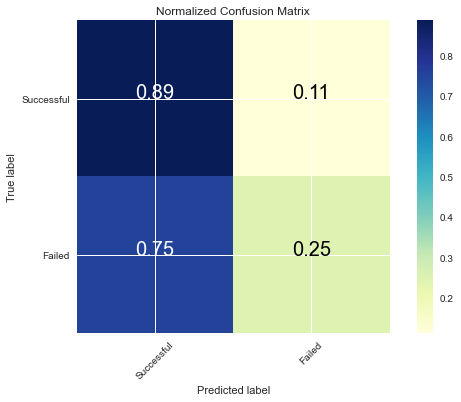

In [25]:
# CONFUSION MATRIX SVM

def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.YlGnBu):
    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
            size="20")
           
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# confusion matrix: confusion_matrix(y_true, y_pred)
cnf_matrix = metrics.confusion_matrix(y_valid, y_pred_valid)
np.set_printoptions(precision=2)
class_names = ['Successful', 'Failed']

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized Confusion Matrix')

# evaluation of confusion matrix
print("-"*60)
print('[ACCURACY]\t %.2f%%' %(metrics.accuracy_score(y_valid, y_pred_valid_SVM)*100))
print('[PRECISION]\t %.2f%%' %(metrics.precision_score(y_valid, y_pred_valid_SVM)*100))
print('[RECALL]\t %.2f%%' %(metrics.recall_score(y_valid, y_pred_valid_SVM)*100))
print("-"*60)